<div style="text-align: center;">
    <h1> <font style="bold"> TD VI: Inteligencia Artificial </font></h1>
    <h2><font style="bold">Trabajo práctico 2 </font></h2>
    <h3><font style="bold">Integrantes:</font></h3>
</div>
<div style="display: flex; justify-content: center;">
    <h4><ul>
        <li>Noguera Azul</li>
        <li>Gonzalez Rocio</li>
        <li>Guledjian Patricio</li>
        </ul>
    </h4>
</div>

In [497]:
import pandas as pd
import numpy as np
import gc
import math
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from hyperopt import hp, fmin, tpe, space_eval, STATUS_OK
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy import stats
import pycircular
from datetime import datetime
from math import sin, cos, pi
from random import randint, uniform
from xgboost import XGBClassifier
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
import re
import xgboost as xgb
from matplotlib import pyplot
import networkx as nx
import zipfile
import os
from unidecode import unidecode
from sklearn.model_selection import GridSearchCV

# !pip install -U gensim
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import re

import gensim # Para word2vec.
import logging # Para configurar el monitoreo de gensim.


In [416]:
# Load the competition data
df = pd.read_csv("competition_data.csv")

# Análisis Exploratorio de Datos

## Eliminación de variables inutiles 

La descripcion del dataset determinaba algunas de las variables como invalidas, estas son:

- benefit
- decimals
- etl_version
- rn

Se eliminan de la base antes de continuar con el analisis.

In [417]:
df = df.drop(['benefit', 'etl_version'], axis=1)

Ademas, la variable total_gmv_domain_bday es una transformacion lineal de la variable total_gmv_domain_30days, por lo que tambien se elimina de la base.

In [418]:
df = df.drop(['total_gmv_domain_bday'], axis=1)

## Análisis de las variables numéricas

Comenzaremos analizando las variables numéricas que podrían no aportarnos valor a la predicción del modelo. 

In [419]:
df_num = df.select_dtypes(include='number')
df_bool = df.select_dtypes(include='bool')

In [420]:
print('\nVariables Numericas:')
for column in df_num:  
  print(column,":\t",df_num[column].nunique()) 


Variables Numericas:
available_quantity :	 6937
avg_gmv_item_domain_30days :	 17727
avg_gmv_item_sel :	 18652
avg_gmv_seller_bday :	 18634
avg_qty_orders_item_domain_30days :	 16760
avg_qty_orders_item_sel_30days :	 15129
avg_si_item_sel_30day :	 15527
conversion :	 2
health :	 35
product_id :	 4440
offset :	 209
original_price :	 6469
price :	 6029
print_position :	 10902
qty_items_dom :	 4193
qty_items_sel :	 1462
sold_quantity :	 5718
total_asp_item_domain_30days :	 17729
total_asp_item_sel_30days :	 18651
total_gmv_item_30days :	 45132
total_items_domain :	 10309
total_items_seller :	 3240
total_orders_domain_30days :	 7882
total_orders_item_30days :	 635
total_orders_sel_30days :	 4413
total_si_domain_30days :	 9157
total_si_item_30days :	 850
total_si_sel_30days :	 5301
total_visits_domain :	 17646
total_visits_item :	 9618
total_visits_seller :	 17762
user_id :	 139110
ROW_ID :	 19211


In [421]:
print('Variables Booleanas:')
for column in df_bool:  
   print(column,":\t",df_bool[column].nunique()) 

Variables Booleanas:
accepts_mercadopago :	 1
boosted :	 1
free_shipping :	 2
fulfillment :	 2


Notamos que las variables *accepts_mercadopago* y *boosted* contienen un unico valor posible. Por lo que lo unico que le aportará al modelo es tiempo computacional, que no queremos!

Por otro lado, las variables *product_id* y *user_id* no las tendremos en cuenta porque en su mayor proporción se encuentran vacias y no aportan información a la predicción. 

In [422]:
df = df.drop(columns=["product_id", "user_id", "accepts_mercadopago", "boosted"])

Para finalizar el apartado del analisis de variables numericas, nos gustaria agregar una nueva columna que creemos significativa para predecir la conversión. Notamos que tenemos dos variables *original_price* y *price*. El ratio de las mismas podría encontranse significativas, chequeemos...

In [423]:
df["discount"] = (df["original_price"] - df["price"]) / df["original_price"]

Analicemos si *discount* presenta correlación con la conversión de los productos de mercado libre:

In [424]:
# Analizamos correlación entre discount (la nueva variable) y conversion
contingency_table = pd.crosstab(df['discount'], df['conversion'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("P-value:", p)

Chi-square: 23382.692434687342
P-value: 0.0


Un valor alto de Chi-cuadrado indica una discrepancia significativa entre las variables. Además, el valor p es 0.0, lo que significa que la probabilidad de obtener un valor de Chi-cuadrado tan alto (o más alto) bajo la suposición de independencia es esencialmente nula. Esto proporciona una fuerte evidencia en contra de la hipótesis nula de independencia y sugiere que las variables están correlacionadas.

### Analisis de Nulos

In [425]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199972 entries, 0 to 199971
Data columns (total 51 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   available_quantity                 199972 non-null  int64  
 1   avg_gmv_item_domain_30days         195607 non-null  float64
 2   avg_gmv_item_sel                   195607 non-null  float64
 3   avg_gmv_seller_bday                195607 non-null  float64
 4   avg_qty_orders_item_domain_30days  195607 non-null  float64
 5   avg_qty_orders_item_sel_30days     195607 non-null  float64
 6   avg_si_item_sel_30day              195607 non-null  float64
 7   category_id                        199972 non-null  object 
 8   conversion                         180761 non-null  float64
 9   date                               199972 non-null  object 
 10  deal_print_id                      199972 non-null  object 
 11  domain_id                          1999

Es importante destacar que notamos 4365 registros con muchas columnas nulas en nustro dataset. Trabajaremos con ellos para mejorar la performance de la predicción:

In [426]:
%%capture
mask = df_num["avg_gmv_item_domain_30days"].isna()
del df_num
df[mask]

Para que el analisis mantenga su consistencia se decide imputar los nulos presentados reemplazandolos por la mediana de la variable con los datos de entrenamiento. 
Las variables sobre las que se hara este proceso son:
- avg_gmv_item_domain_30days         
- avg_gmv_item_sel                  
- avg_gmv_seller_bday                
- avg_qty_orders_item_domain_30days  
- avg_qty_orders_item_sel_30days    
- avg_si_item_sel_30day 
- qty_items_dom                 
- qty_items_sel
- total_asp_item_domain_30days      
- total_asp_item_sel_30days     
- total_gmv_domain_bday            
- total_gmv_item_30day
- total_orders_domain_30days   
- total_orders_item_30days         
- total_orders_sel_30days      
- total_si_domain_30days         
- total_si_item_30days        
- total_si_sel_30days

In [427]:
# Valores Medios
columnas = ['avg_gmv_item_domain_30days', 'avg_gmv_item_sel','avg_gmv_seller_bday', 'avg_qty_orders_item_domain_30days', 'avg_qty_orders_item_sel_30days',    
            'avg_si_item_sel_30day', 'qty_items_dom', 'qty_items_sel', 'total_asp_item_domain_30days', 'total_asp_item_sel_30days',     
            'total_gmv_item_30days', 'total_orders_domain_30days', 'total_orders_item_30days', 'total_orders_sel_30days',      
            'total_si_domain_30days', 'total_si_item_30days', 'total_si_sel_30days']
for columna in columnas:
    df[columna] = df[columna].fillna(df[df["ROW_ID"].isna()][columna].median()) 

La variable *is_pdp* tiene nulos, pero se los imputa con un nuevo valor ya que su comportamiento no corresponde al resto:

In [428]:
df['is_pdp'] = df['is_pdp'].astype(str)
df['is_pdp'].fillna('nan', inplace=True)

## Análisis las variables categoricas

In [429]:
df_categoricas = df.select_dtypes(include='object')

In [430]:
for column in df_categoricas:  
   print(column, df_categoricas[column].nunique()) 

category_id 2284
date 31
deal_print_id 196744
domain_id 1742
full_name 2280
is_pdp 3
item_id 27695
listing_type_id 2
logistic_type 7
main_picture 26961
platform 4
print_server_timestamp 196780
site_id 1
tags 1227
title 26745
uid 159996
warranty 1288


<!-- Se eliminan las variables de id (category_id, deal_print_id, domain_id, item_id) del analisis: no son representativas para la prediccion. -->
Se eliminan las variables de id que no son representativas:

- deal_print_id: unique id for the print --> 'a9cb2270-5f61-11ea-89fc-13e674cbfad4', '17bfe7b0-7480-11ea-a387-65bd48ab9972', 'b36b3570-79e9-11ea-abe3-5f57eda5c45c' ...
- uid: session id --> 'cb5bfac7-229a-4e3e-96dd-80b2ad3972c1', 'b0f9aa19-00d5-4afd-aa77-45be7c849562', 'fd59890a-f2c2-4282-b2ee-c68f25e20697' ...

In [431]:
df = df.drop(["deal_print_id", "uid"], axis=1)
df_categoricas = df.select_dtypes(include='object')

Se separan las variables temporales:

- date
- print_server_timestamp

In [432]:
df_temporales = df[["date","print_server_timestamp"]]
df_categoricas = df_categoricas.drop(df_temporales, axis=1)

Se separan las variables de texto:

- full_name
- title
- tags

In [433]:
df_text = df[["full_name","title",'tags']]
df_categoricas = df_categoricas.drop(df_text, axis=1)

Para continuar con el analisis notamos que la variable *warranty* es de tipo objeto pero en realidad esta detallando si tiene garantia (cuanto tiempo) o no. Por lo tanto, intentaremos modificar esa variable y analizaremos la garantía de los productos tiene o no una correlación con la conversión.

Primero se formatea para intentar sacar la mayor cantidad de duplicados:

- Convertir a Minusculas
- Eliminar tildes y caracteres especiales
- Eliminar espacios dobles
- Eliminar espacios al principio y al final de la oración.

In [434]:
# Eliminar los espacios enfrente y atras de las variables.
df_categoricas['warranty'] = df_categoricas['warranty'].apply(lambda x: x.strip() if isinstance(x, str) else x)
# Le saco las tildes a la base:
df_categoricas['warranty'] = df_categoricas['warranty'].apply(lambda x: unidecode(x) if isinstance(x, str) else x)
# Lo convierto a minusculas
df_categoricas['warranty'] = df_categoricas['warranty'].apply(lambda x: x.lower() if isinstance(x, str) else x)
# Le saco los espacios dobles.
df_categoricas['warranty'] = df_categoricas['warranty'].apply(lambda x: x.replace('  ',' ') if isinstance(x, str) else x)

In [435]:
def categorizar_garantia(garantia):
    garantia = str(garantia)
    if ("fabrica" in garantia) or ('marca' in garantia):
        return "garantia de fabrica"
    elif "vendedor" in garantia:
        return "garantia del vendedor"
    elif "sin garantia" in garantia:
        return "sin garantia"
    elif ('hora' in garantia) or ('hs' in garantia) or ('dia' in garantia) or ('mes'in garantia) or ('ano' in garantia) or ('vida' in garantia) or ('garantizamos' in garantia) or ('gtia' in garantia) or ('garantia' in garantia) or ('si' in garantia):
        return 'garantia'
    else:
        return "sin garantia"

In [436]:
# Aplica la función a la columna "garantia"
df_categoricas["cat_warranty"] = df_categoricas["warranty"].apply(categorizar_garantia)

In [437]:
df_categoricas["cat_warranty"].value_counts()

garantia de fabrica      77399
sin garantia             72952
garantia del vendedor    37228
garantia                 12393
Name: cat_warranty, dtype: int64

Analicemos la correlación de la variable *warranty* con la variable *conversion*:

In [438]:
# Analizamos correlación entre cat_warranty y conversion
contingency_table = pd.crosstab(df_categoricas['cat_warranty'], df['conversion'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("P-value:", p)

Chi-square: 126.2365510005184
P-value: 3.499566183925306e-27


A partir de el analisis de correlación (Chi cuadrado) notamos que existe una asociación significativa entre las dos variables categóricas. Por lo que la utilizaremos en el modelo para estimar la probabilidad de conversion.

In [439]:
df = pd.concat([df,df_categoricas["cat_warranty"]], axis=1)
df = df.drop(['warranty'], axis = 1) 

La variable *platform* se puede dividir ademas en si el usuario esta desde la web o mobile.

In [440]:
df['platform'].unique()

array(['/web/desktop', '/mobile/android', '/web/mobile', '/mobile/ios'],
      dtype=object)

In [441]:
df_categoricas['platform_web'] = df_categoricas['platform'].str.contains('web', case=False)

In [442]:
df = pd.concat([df,df_categoricas["platform_web"]], axis=1)

Se elimina la variable porque solo tiene una categorica:

- site_id

In [443]:
df = df.drop('site_id', axis=1)

Se cree que el tipo de logistica no tiene una relacion natural con la variable resultado. Uno no decide si hacer una compra o no segun el tipo de logistica que utilice el comerciante para transportar su producto. Pero se procede a evaluar si existe una correlacion empirica. En caso de no haberla, se descartara la variable del analisis.

In [444]:
# Analizamos correlación entre logistic_type y conversion
contingency_table = pd.crosstab(df['logistic_type'], df['conversion'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("P-value:", p)

Chi-square: 761.455399863375
P-value: 3.269950268794381e-161


En base a los resultados del Chi-cuadrado, podemos concluir que hay una correlación o asociación significativa entre las dos variables en estudio.

La variable main_picture presenta la imagen del producto. Creemos relevante para la decision de compra el hecho de existir o no imagen. Por eso crearemos una variable booleana que describa esta situacion. 

In [445]:
mp["new_main_picture"] = df["main_picture"]
mp["new_main_picture"] = mp["new_main_picture"].apply(lambda x: 0 if pd.isna(x) else 1)


In [446]:
# Analizamos correlación entre logistic_type y conversion
# Asegurándose de que son Series y no DataFrames
main_picture_series = mp["new_main_picture"].squeeze()
conversion_series = df["conversion"].squeeze()

# Creando la tabla de contingencia
contingency_table = pd.crosstab(main_picture_series, conversion_series)
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("P-value:", p)


Chi-square: 24.795785024690137
P-value: 6.373669010903951e-07


Observamos que los valores nulos no parecen originarse de impresiones sin imágenes, sino más bien de la pérdida de datos dentro del conjunto de datos. Esta observación se refuerza al analizar la página web de Mercado Libre, donde determinamos que no es posible listar un producto a la venta sin una imagen. Esto desacredita nuestra teoría inicial de que los valores nulos representaban impresiones sin imágenes. A continuación, evaluaremos si la variable 'main_picture' por sí misma presenta alguna correlación con la variable *conversión*.

In [447]:
# Analizamos correlación entre main_picture y conversion
contingency_table = pd.crosstab(df['main_picture'], df['conversion'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("P-value:", p)

Chi-square: 29055.05497503387
P-value: 1.9747473512447793e-90


Notamos una gran correlación por lo que dejaremos la variable *main_picture* como estaba en el dataset original.

## Análisis de variables Temporales

Las variables temporales pueden influir mucho en el comportamiento del consumidor. Se debe evaluar y tener en cuenta el momento en el que estan visitando la pagina ya que puede determinar si se realiza o no la conversion. Es por eso que se realiza un encoding de estas variables.

In [448]:
# Modificamos el tipo de datos a datetime.
df["date"] = pd.to_datetime(df["date"])
df["print_server_timestamp"] = pd.to_datetime(df["print_server_timestamp"])
df[["date","print_server_timestamp"]]

,date,print_server_timestamp
0,2020-03-06,2020-03-06 00:19:30.735000-04:00
1,2020-04-01,2020-04-01 21:20:11.738000-04:00
2,2020-04-08,2020-04-08 18:38:48.360000-04:00
3,2020-04-25,2020-04-25 22:01:19.829000-04:00
4,2020-03-10,2020-03-10 13:20:56.633000-04:00
...,...,...
199967,2020-04-12,2020-04-12 14:35:44.784000-04:00
199968,2020-04-03,2020-04-03 17:32:53.035000-04:00
199969,2020-04-01,2020-04-01 22:51:08.898000-04:00
199970,2020-04-08,2020-04-08 11:32:27.563000-04:00


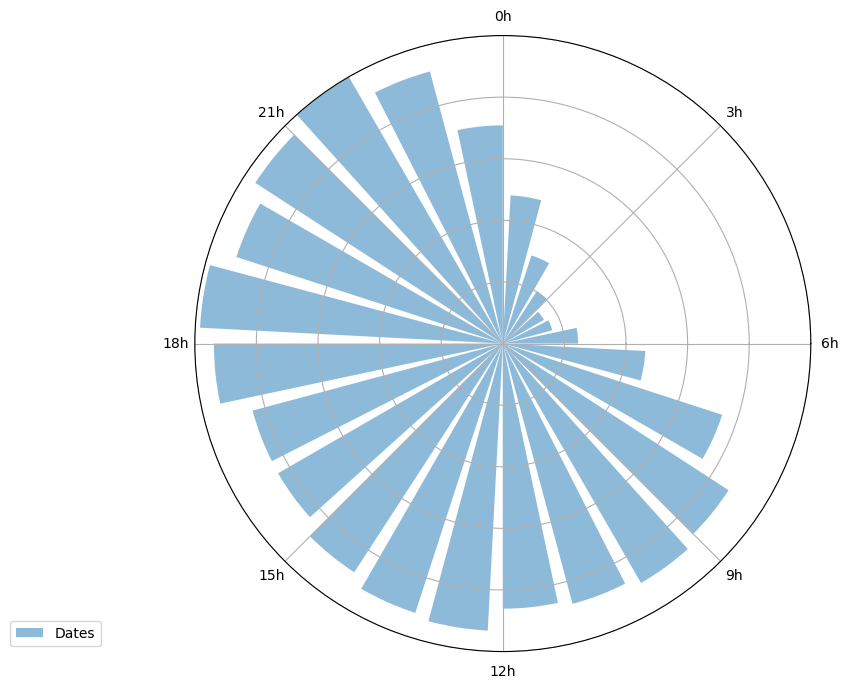

In [449]:
time_segment = 'hour'  
freq_arr, times = pycircular.utils.freq_time(df["print_server_timestamp"] , time_segment=time_segment)
fig, ax1 = pycircular.plots.base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment)
ax1.legend(bbox_to_anchor=(-0.3, 0.05), loc="upper left", borderaxespad=0)

plt.show()

Combinando las funciones seno y coseno podemos caracterizar una variable cíclica. Esto se simula de esta manera para que las variables tengan un sentido ciclico y no lineal. Por ejemplo, en el caso de las horas la hora 00 y la hora 23 en la realidad estan muy cerca una de la otra. Si se las analiza linealmente perderian esta propiedad, pero si se les hace un encoding calculando sus seno y coseno se mantendria. 
Se realizara este analisis con las horas, los dias de la semana y los dias del mes.
No se realiza sobre el mes porque solo hay dos meses.

Para las horas:

In [450]:
# Unidad de tiempo:
cantidad_tiempo = 24

# Calculo Seno y Coseno
seno = np.sin((df["print_server_timestamp"].dt.hour*(2*math.pi/cantidad_tiempo)))
coseno = np.cos((df["print_server_timestamp"].dt.hour*(2*math.pi/cantidad_tiempo)))

df['hour_sin'] = seno
df['hour_cos'] = coseno


Para los dias de la semana:

In [451]:
# Unidad de tiempo:
cantidad_tiempo = 7

# Calculo Seno y Coseno
seno = np.sin((df["print_server_timestamp"].dt.weekday*(2*math.pi/cantidad_tiempo)))
coseno = np.cos((df["print_server_timestamp"].dt.weekday*(2*math.pi/cantidad_tiempo)))

df['weekday_sin'] = seno
df['weekday_cos'] = coseno

Para los dias del mes:

In [452]:
# Como solo hay mes 3 y 4 aplicamos una regla para determinar la cantidad de dias en cada uno de los meses:
df["days_in_month"] = df["print_server_timestamp"].dt.month.apply(lambda x: 31 if x == 3 else 30)

# Calculo Seno y Coseno
seno = np.sin((df["print_server_timestamp"].dt.day*(2*math.pi/df["days_in_month"])))
coseno = np.cos((df["print_server_timestamp"].dt.day*(2*math.pi/df["days_in_month"])))

df['day_sin'] = seno
df['day_cos'] = coseno

df = df.drop(columns = ["days_in_month"])


In [453]:
df = df.drop(columns = ["date","print_server_timestamp"])

## Análisis de variables de texto

In [454]:
df_text.columns

Index(['full_name', 'title', 'tags'], dtype='object')

In [455]:
# Eliminar los espacios enfrente y atras de las variables.
df_text = df_text.applymap(lambda x: x.strip() if isinstance(x, str) else x)
# Le saco las tildes a la base:
df_text = df_text.applymap(lambda x: unidecode(x) if isinstance(x, str) else x)
# Lo convierto a minusculas
df_text = df_text.applymap(lambda x: x.lower() if isinstance(x, str) else x)
# Le saco los espacios dobles.
df_text = df_text.applymap(lambda x: x.replace('  ',' ') if isinstance(x, str) else x)

#### Name

En el caso de *full_name* se extrae la primer categoria:

In [456]:
df_text['name'] = df['full_name'].str.split('-', n=1).str[0]

In [457]:
df_text['name'].nunique()

32

Como son 32 clases, se podria realizar un Encoding sobre esta variable.

In [458]:
# Analizamos correlación entre name y conversion
contingency_table = pd.crosstab(df_text['name'], df['conversion'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("P-value:", p)

Chi-square: 2091.2717780728476
P-value: 0.0


Basándonos en estos resultados, podemos concluir que hay una correlación significativa entre las dos variables en estudio.

In [459]:
df_categoricas['name'] = df_text['name']

Agregamos la columna a df...

In [460]:
df = pd.concat([df,df_categoricas["name"]], axis=1)
df = df.drop(['full_name'], axis = 1) 

#### Tags

In [461]:
# Eliminar las llaves
df_text['tags'] = df_text['tags'].str.replace('[\[\]]', '', regex=True)

In [462]:
# Dividir las etiquetas en listas y luego codificarlas en variables binarias
tags_encoded = df_text['tags'].str.get_dummies(sep=', ')

# Agregar las variables binarias al DataFrame original
df_text = pd.concat([df_text, tags_encoded], axis=1)

In [463]:
df = df.drop(['tags'], axis = 1) 

#### Title

In [464]:
titles = df['title']

In [465]:
titles.str.len().describe()

count    199972.000000
mean         54.695102
std          12.580939
min           8.000000
25%          50.000000
50%          57.000000
75%          59.000000
max         120.000000
Name: title, dtype: float64

In [466]:
logging.basicConfig(format = '%(levelname)s - %(asctime)s: %(message)s',
                    datefmt = '%H:%M:%S',
                    level = logging.INFO)

In [467]:
def tokenize(raw_text):
    '''Realiza la tokenización.'''
    
    sentences = sent_tokenize(raw_text, language = 'spanish')
    tokens = [token for sentence in sentences for token in word_tokenize(sentence)] # Generación de una lista por comprensión anidada.
    tokens = [token.lower() for token in tokens if re.compile('[A-Za-z]').search(token[0])] # re.compile para que cada token tenga, al menos, una letra.
    
    return(tokens)

In [468]:
tokenized_titles = [tokenize(titles[i]) for i in range(len(titles))]

In [469]:
tokenized_titles[0]

['motorola', 'one', 'action', 'gb', 'denim', 'blue', 'gb', 'ram']

In [470]:
# RETRAIN_W2VEC = True
RETRAIN_W2VEC = True

windows = [5, 20]

In [471]:
import os

# Obtiene la ruta absoluta de los archivos de modelo
model_file_path_sw = os.path.abspath('word2vec-titulos-tp2-window5.model')
model_file_path_bw = os.path.abspath('word2vec-titulos-tp2-window20.model')
model_file_path_sw, model_file_path_bw


('/Users/achula/achula/td6 - Inteligencia Artificial/tp2-g11/word2vec-titulos-tp2-window5.model',
 '/Users/achula/achula/td6 - Inteligencia Artificial/tp2-g11/word2vec-titulos-tp2-window20.model')

In [472]:
if RETRAIN_W2VEC:
    models = [0, 0]
    for i in range(len(windows)):
        # Definimos los parámetros del modelo.
        models[i] = gensim.models.Word2Vec(vector_size = 50,
                                           window = windows[i],
                                           min_count = 1,
                                           negative = 5,
                                           workers = 4)
        
        # Hacemos una pasada por el corpus y creamos el vocabulario.
        models[i].build_vocab(tokenized_titles,
                              progress_per = 10000)
        
        # Entrenamos el modelo.
        models[i].train(tokenized_titles,
                        total_examples = models[i].corpus_count,
                        epochs = 20,
                        report_delay = 1)
        
        # Guardamos el modelo en disco.
        models[i].save(f'word2vec-titulos-tp2-window{windows[i]}.model')
    
    model_sw = models[0]
    model_bw = models[1]
    del models
    gc.collect()
else:
    # Cargamos los modelos ya entrenados.
    model_sw = gensim.models.Word2Vec.load(os.path.abspath('word2vec-titulos-tp2-window5.model'))
    model_bw = gensim.models.Word2Vec.load(os.path.abspath('word2vec-titulos-tp2-window20.model'))

INFO - 17:39:16: Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=50, alpha=0.025)', 'datetime': '2023-10-03T17:39:16.317940', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 18:29:29) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
INFO - 17:39:16: collecting all words and their counts
INFO - 17:39:16: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 17:39:16: PROGRESS: at sentence #10000, processed 75382 words, keeping 9334 word types
INFO - 17:39:16: PROGRESS: at sentence #20000, processed 150361 words, keeping 12108 word types
INFO - 17:39:16: PROGRESS: at sentence #30000, processed 225572 words, keeping 13723 word types
INFO - 17:39:16: PROGRESS: at sentence #40000, processed 300690 words, keeping 14924 word types
INFO - 17:39:16: PROGRESS: at sentence #50000, processed 375854 words, keeping 15882 word types
INFO - 17:39:16: PROGRESS: at sentence #60000, processed 451486 words, keeping 16657 wo

In [473]:
print(titles[1])
print('zapatillas')
print(model_sw.wv.__getitem__(['zapatillas']))
print(model_bw.wv.__getitem__(['zapatillas']))

Zapatillas Hovr Sonic 2 Under Armour
zapatillas
[[-7.2965374   0.8348067   0.47448373 -0.5536704   0.01030286 -0.48870245
   3.194742    1.005055    0.55542433 -0.44729117 -5.314159    0.59212273
   3.4080186  -4.328305   -0.44619063  5.105093   -1.8390945  -1.0884664
   3.390002   -0.39422488  1.1024365   1.3340161   1.2842056  -3.5337667
  -0.16646002 -5.33542     3.9577825  -0.07195739  0.2725537  -4.990869
  -0.11640905  2.6337016  -1.150472   -1.5620751   0.40767506  4.635728
   5.236031   -0.09551629  0.31192636 -0.3099635   3.9360194   0.7207978
   1.7730252   2.0548205   3.9908364  -4.6645436  -2.4519536  -0.10260505
  -0.49798596  5.760092  ]]
[[-6.995825    2.040546   -1.3634207   2.504669    1.1204983   0.7854509
   2.8418052   0.78953546 -1.0591218   0.18403168 -5.3804846  -0.479868
   2.793435   -4.059405   -0.94969934  4.357584    0.06208616 -0.8158295
   0.76660806 -2.1101186  -0.17903605  0.45076293  2.8252196  -3.0677433
  -1.4875427  -1.814665    2.396466    0.7371374

## Encoding

Procedemos a analizar las variables categoricas:

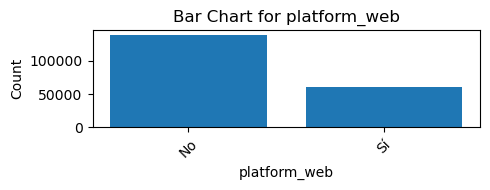

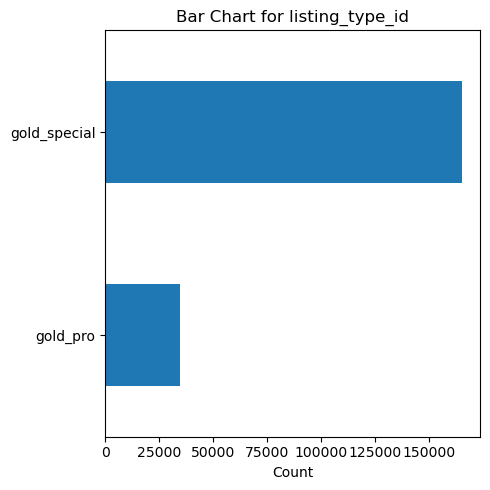

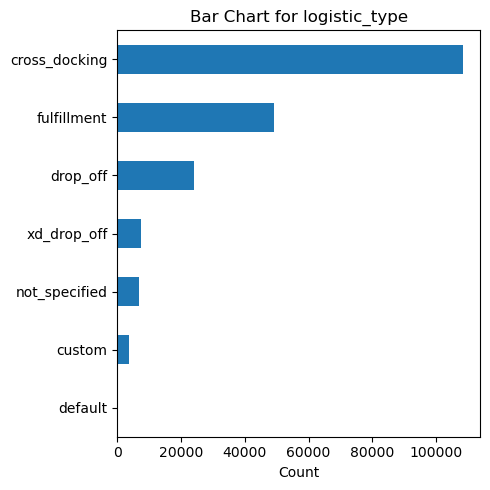

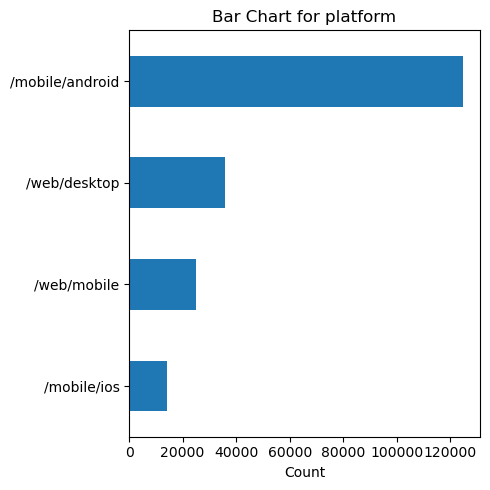

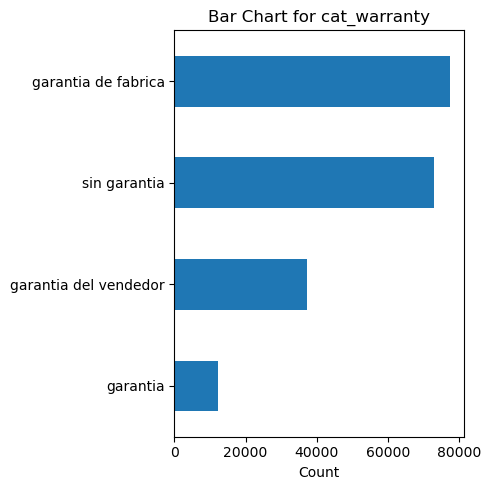

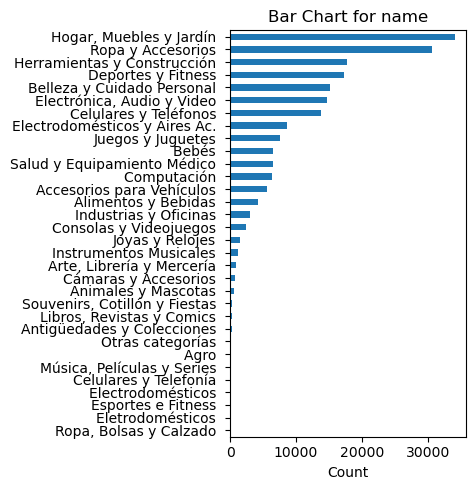

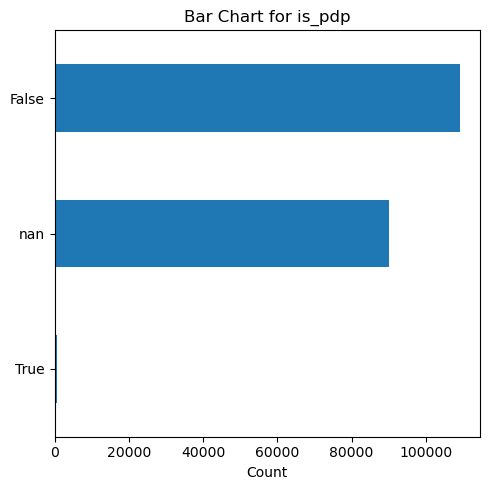

In [474]:
# Iterar a través de las columnas categóricas y crear un gráfico de barras para cada una
for column in df_categoricas[['platform_web']]:  
    categories = df_categoricas[column].value_counts().index
    values = df_categoricas[column].value_counts().values
    

    plt.figure(figsize=(5, 2))  # Tamaño del gráfico (opcional)
    plt.bar(categories, values)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Bar Chart for {column}')
    plt.xticks(rotation=45)  # Rotar etiquetas si son largas
    plt.xticks([0, 1], ['No', 'Sí']) 
    plt.tight_layout()  # Ajustar el diseño
    plt.show()

# Iterar a través de las columnas categóricas y crear un gráfico de barras para cada una
for column in df_categoricas[["listing_type_id","logistic_type", "platform",'cat_warranty','name', 'is_pdp']]:  
    # Cuenta la frecuencia de cada especie y ordena de mayor a menor
    frecuencia = df_categoricas[column].value_counts().sort_values(ascending=True)

    # Crea un gráfico de barras horizontal
    plt.figure(figsize=(5, 5))  # Ajusta el tamaño si es necesario
    frecuencia.plot(kind='barh')  # Usa 'barh' para gráfico de barras horizontal
    plt.xlabel('Count')
    plt.title(f'Bar Chart for {column}')
    plt.tight_layout()
    plt.show()

Como resulta significativa la prueba de chi-cuadrado, se concluye que la variable logistic_type presenta una correlacion empirica. Es por eso que se decide hacer OneHotEncoding con la misma.

A pesar de que hayamos visto unicamente OHE en la clase, quisimos probar diferentes tipos de tecnicas de enconding en las variables categoricas. 
- OHE (One-Hot Encoding): conocido por las clases teoricas. 
- LE (Label Encoding): Asigna a cada categoría un valor numérico único, generalmente de 0 a N-1, donde N es el número de categorías.
- OE (Ordinal Encoding): Similar al Label Encoding, pero se utiliza específicamente para variables categóricas que tienen un orden inherente.
- FE (Frequency Encoding): Codifica las categorías basadas en la frecuencia o proporción de observaciones que tienen esa categoría.
- TE (Target Encoding) o Mean Encoding: Basado en la relación entre la categoría y el objetivo (target).

Las variables booleanas ya tienen Encoding.

- picture
- platform_web

En el resto de variables categoricas se evalua que tipo de encoding es el mas eficiente:

- category_id
- domain_id
- item_id
- name
- listing_type_id
- logistic_type
- platform
- cat_warranty
- is_pdp

In [476]:
# Definir las columnas a las que se aplicará One-Hot Encoding
columns_to_OHE = ['listing_type_id', 'logistic_type', 'platform', 'cat_warranty', 'is_pdp']

# Aplicar One-Hot Encoding a las columnas especificadas
df = pd.get_dummies(df, columns=columns_to_OHE, prefix=columns_to_OHE)

In [477]:
# Definir las columnas a las que se aplicará Frequency Encoding
columns_to_FE = ['category_id', 'domain_id', 'item_id', 'name']

# Aplicar Frequency Encoding a las columnas especificadas
for col in columns_to_FE:
    freq_map = df[col].value_counts(normalize=True)  # normalize=True retorna proporciones en vez de conteos
    df[col] = df[col].map(freq_map)

In [478]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199972 entries, 0 to 199971
Data columns (total 67 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   available_quantity                  199972 non-null  int64  
 1   avg_gmv_item_domain_30days          199972 non-null  float64
 2   avg_gmv_item_sel                    199972 non-null  float64
 3   avg_gmv_seller_bday                 199972 non-null  float64
 4   avg_qty_orders_item_domain_30days   199972 non-null  float64
 5   avg_qty_orders_item_sel_30days      199972 non-null  float64
 6   avg_si_item_sel_30day               199972 non-null  float64
 7   category_id                         199972 non-null  float64
 8   conversion                          180761 non-null  float64
 9   domain_id                           199972 non-null  float64
 10  free_shipping                       199972 non-null  bool   
 11  fulfillment               

# Exploración e Implementación del Modelo 

Una vez finalizado el analisis exploratorio de datos (EDA), se procede a la exploracion e implementacion del modelo.

- Train: 80%
- Val: 20%
- Test: de testeo.

In [482]:
# Split into training and evaluation samples
train_data = df[df["ROW_ID"].isna()]
test_data = df[df["ROW_ID"].notna()]
del(df)

In [483]:
train_data = train_data.select_dtypes(include='number')
train_data = train_data.drop(columns=["ROW_ID"])
X_train, X_val, y_train, y_val = train_test_split(train_data.drop(columns=["conversion"]), train_data['conversion'], test_size=0.2)
del train_data

In [484]:
X_test = test_data.drop(columns=["conversion", "ROW_ID"])
X_test = X_test.select_dtypes(include='number')

## XG Boost

### Optimización

In [479]:
%%capture
model_xgb_2 = XGBClassifier(n_jobs=-1, use_label_encoder=False)

In [480]:
grid = {'max_depth': stats.randint(5,12),
              'learning_rate': stats.uniform(0.05, 0.5),
              'subsample': stats.uniform(0.1, 1),
              'colsample_bytree': stats.uniform(0.1, 1),
              'min_child_weight': stats.randint(1,4),
              'n_estimators': stats.randint(50, 1000)
             }

In [481]:
search_spaces = {
    'n_estimators': (10, 200),
    'max_depth': (1, 32),
    'min_samples_split': (2, 20),
}

##### Random Search:

In [ ]:
optimizer = Optimization(model=model, param_grid=grid, n_iter=10, cv=5, random_state=42)

### Prueba 2: 


In [485]:
%%capture
model_xgb_A = XGBClassifier(n_jobs=3, use_label_encoder=False)

In [486]:
%%capture
param_dist_A = {'max_depth': stats.randint(5,12),
              'learning_rate': stats.uniform(0.05, 0.5),
              'subsample': stats.uniform(0.1, 1),
              'colsample_bytree': stats.uniform(0.1, 1),
              'min_child_weight': stats.randint(1,4),
              'n_estimators': stats.randint(50, 1000)
             }
cv = StratifiedKFold(n_splits=3, random_state=41, shuffle=True)

xgb_random_A = RandomizedSearchCV(model_xgb_A,param_dist_A, cv=cv, verbose=1, n_jobs=3, scoring='roc_auc', n_iter=40, random_state=15)
xgb_random_A.fit(X_train,y_train)

In [487]:
xgb_random_A.best_params_

{'colsample_bytree': 0.1664474589125239,
 'learning_rate': 0.09192844711931981,
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 229,
 'subsample': 0.9278123360964413}

In [488]:
xgb_random_A.best_score_

0.8909068667134991

Iteraciones de el modelo que mejor performance tuvo:

In [489]:
for i, score in enumerate(xgb_random_A.cv_results_['mean_test_score']):
    print(f"Iteraciones {i+1}: auc_roc = {score:.4f}")

Iteraciones 1: auc_roc = 0.8846
Iteraciones 2: auc_roc = 0.8732
Iteraciones 3: auc_roc = nan
Iteraciones 4: auc_roc = 0.8589
Iteraciones 5: auc_roc = 0.8667
Iteraciones 6: auc_roc = 0.8416
Iteraciones 7: auc_roc = 0.8838
Iteraciones 8: auc_roc = 0.8708
Iteraciones 9: auc_roc = 0.8300
Iteraciones 10: auc_roc = 0.8907
Iteraciones 11: auc_roc = 0.8844
Iteraciones 12: auc_roc = 0.8410
Iteraciones 13: auc_roc = 0.8344
Iteraciones 14: auc_roc = 0.8772
Iteraciones 15: auc_roc = 0.8751
Iteraciones 16: auc_roc = 0.8801
Iteraciones 17: auc_roc = 0.8650
Iteraciones 18: auc_roc = 0.8634
Iteraciones 19: auc_roc = 0.8362
Iteraciones 20: auc_roc = 0.8784
Iteraciones 21: auc_roc = nan
Iteraciones 22: auc_roc = nan
Iteraciones 23: auc_roc = 0.8799
Iteraciones 24: auc_roc = 0.8786
Iteraciones 25: auc_roc = 0.8661
Iteraciones 26: auc_roc = 0.8782
Iteraciones 27: auc_roc = 0.8673
Iteraciones 28: auc_roc = 0.8760
Iteraciones 29: auc_roc = 0.8811
Iteraciones 30: auc_roc = nan
Iteraciones 31: auc_roc = nan
I

In [490]:
# Predict on the evaluation set
y_pred_A = xgb_random_A.predict_proba(X_test)[:,1]
y_pred_A

array([2.7515434e-02, 6.2389474e-05, 1.3373195e-01, ..., 1.2537888e-04,
       8.1122890e-02, 2.8375924e-05], dtype=float32)

In [491]:
# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_pred_A})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("xgb_A.csv", sep=",", index=False)

#### Importancia de Variables

<Figure size 1200x3000 with 0 Axes>

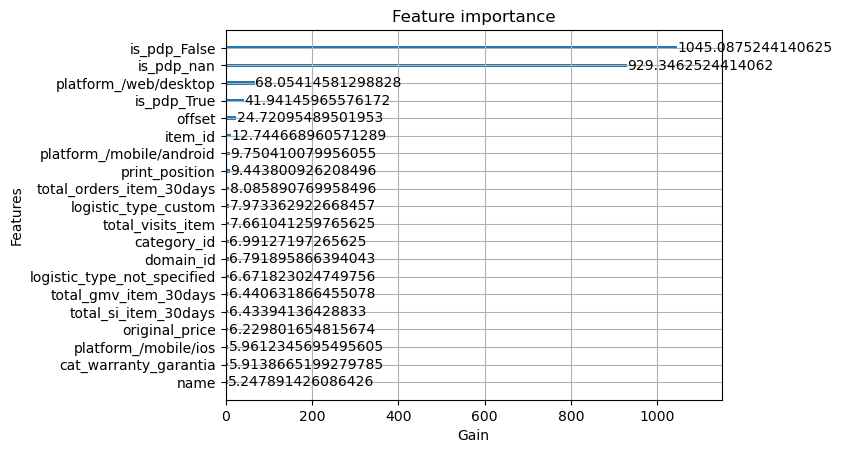

In [492]:

# Obtener el mejor modelo entrenado de tu RandomizedSearchCV
best_model_xgb_A = xgb_random_A.best_estimator_

# Ajustar el tamaño del gráfico utilizando figsize
plt.figure(figsize=(12, 30))   # Ajusta el tamaño según tus preferencias

# Generar el gráfico de importancia
xgb.plot_importance(best_model_xgb_A, max_num_features=20,  importance_type="gain", xlabel="Gain")

# Mostrar el gráfico
plt.show()

<span style="color:red">La performance del modelo con el 30% de los datos de test (public kaggle competition) dio como resultado: 0.88696</span>

### Prueba 3:

 Ahora utilicemos *early_stopping_rounds* a modo de que el modelo frene luego de que pasen 10 iteraciones en la que la performance no mejora. Este nos ayudará a intentar omitir el overfitting. 

In [498]:
%%capture
xgb_gs = XGBClassifier(n_jobs=3, use_label_encoder=False, early_stopping_rounds=10)

In [500]:
%%capture
# Definir la grilla de parámetros
param_grid = {
    'max_depth': [5, 6, 7], 
    'learning_rate': np.arange(0.05, 0.1),  
    # 'subsample': np.arange(0.1, 1.1), 
    # 'colsample_bytree': np.arange(0.3, 0.91, 0.1), 
    'min_child_weight': [2, 3], 
    'n_estimators': [400, 500, 800, 1000]  
}

# Crear una instancia de StratifiedKFold
cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

# Crear una instancia de GridSearchCV con tu modelo
xgb_gs = GridSearchCV(xgb_gs, param_grid, cv=cv, verbose=1, scoring='roc_auc')

# Ajustar el modelo utilizando GridSearchCV
xgb_gs.fit(X_train, y_train)

ValueError: Invalid parameter learning_rate for estimator GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=10,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=3,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': array([0.05]), 'max_depth': [5, 6, 7],
                         'min_child_weight': [2, 3],
                         'n_estimators': [400, 500, 800, 1000]},
             scoring='roc_auc', verbose=1). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
xgb_gs.best_params_

{'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 800}

In [ ]:
xgb_gs.best_score_

0.8948503248079724

In [ ]:
# Print the accuracy for each iteration
for i, score in enumerate(xgb_gs.cv_results_['mean_test_score']):
    print(f"Iteraciones {i+1}: roc_auc = {score:.4f}")

Iteraciones 1: roc_auc = 0.8924
Iteraciones 2: roc_auc = 0.8932
Iteraciones 3: roc_auc = 0.8943
Iteraciones 4: roc_auc = 0.8946
Iteraciones 5: roc_auc = 0.8925
Iteraciones 6: roc_auc = 0.8934
Iteraciones 7: roc_auc = 0.8944
Iteraciones 8: roc_auc = 0.8948
Iteraciones 9: roc_auc = 0.8935
Iteraciones 10: roc_auc = 0.8941
Iteraciones 11: roc_auc = 0.8949
Iteraciones 12: roc_auc = 0.8947
Iteraciones 13: roc_auc = 0.8937
Iteraciones 14: roc_auc = 0.8942
Iteraciones 15: roc_auc = 0.8945
Iteraciones 16: roc_auc = 0.8944
Iteraciones 17: roc_auc = 0.8946
Iteraciones 18: roc_auc = 0.8948
Iteraciones 19: roc_auc = 0.8944
Iteraciones 20: roc_auc = 0.8941
Iteraciones 21: roc_auc = 0.8943
Iteraciones 22: roc_auc = 0.8946
Iteraciones 23: roc_auc = 0.8943
Iteraciones 24: roc_auc = 0.8939


In [ ]:
# Predict on the evaluation set
y_pred_gs = xgb_gs.predict_proba(X_test)[:,1]
y_pred_gs

array([3.5815734e-02, 3.6029403e-05, 9.6014962e-02, ..., 5.1810421e-05,
       1.7267054e-01, 3.0102408e-05], dtype=float32)

In [ ]:
xgb_gs.best_params_

{'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 800}

In [ ]:
# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_pred_gs})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("xgb_gs.csv", sep=",", index=False)

#### Grafico de performance

In [ ]:
# Suponiendo que grid_search es tu objeto GridSearchCV ya entrenado

best_model = xgb_gs.best_estimator_  # Obtener el mejor modelo

# Entrenar el mejor modelo individualmente para obtener el historial de métricas
evals = [(X_train, y_train), (X_test, y_test)]  # Puedes ajustar esto a tus datos
best_model.fit(X_train, y_train, eval_metric="auc", eval_set=evals, verbose=True)

# Obtener el historial de métricas
train_history = best_model.evals_result()
epochs = len(train_history['validation_0']['auc'])
iterations = range(0, epochs)

# Ahora puedes trazar el historial de AUC-ROC
plt.plot(iterations, train_history["validation_0"]["auc"], label="training data")
plt.plot(iterations, train_history["validation_1"]["auc"], label="validation data")
plt.legend()
plt.ylabel('auc_roc')
plt.title('XGBoost auc_roc')
plt.show()


NameError: name 'y_test' is not defined

#### Importancia de Variables

<Figure size 1200x3000 with 0 Axes>

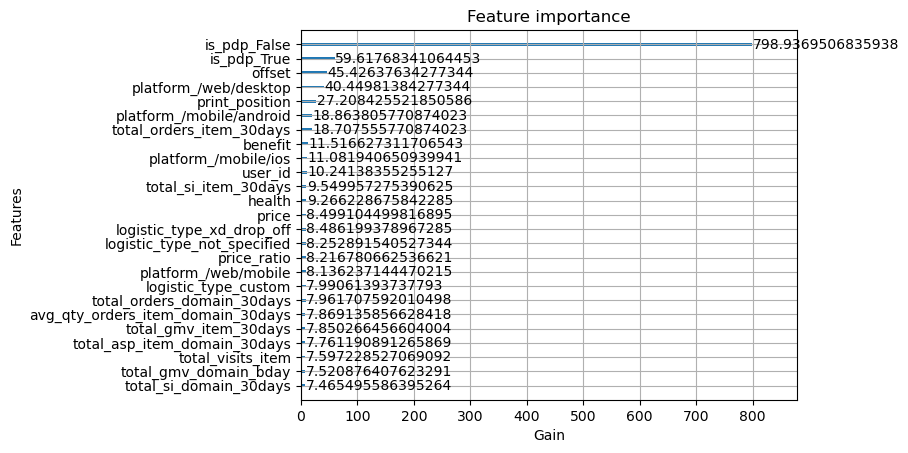

In [ ]:

# Obtener el mejor modelo entrenado de tu RandomizedSearchCV
best_model_xgb = xgb_gs.best_estimator_

# Ajustar el tamaño del gráfico utilizando figsize
plt.figure(figsize=(12, 30))   # Ajusta el tamaño según tus preferencias

# Generar el gráfico de importancia
xgb.plot_importance(best_model_xgb, max_num_features=25,  importance_type="gain", xlabel="Gain")

# Mostrar el gráfico
plt.show()

### Prueba 4

In [528]:
xgb1_fijo = xgb.XGBClassifier(
    objective = 'binary:logistic',
    random_state = 41,
    n_jobs=-1,
    colsample_bytree = 0.6132378121429716,
    learning_rate = 0.1,
    max_depth =7,
    min_child_weight = 3,
    n_estimators= 515,
    subsample= 0.8452823549192477
)

In [529]:
%%capture
xgb1_fijo.fit(X_train, y_train, early_stopping_rounds=15, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='auc', verbose=True)


Text(0.5, 1.0, 'XGBoost auc_roc')

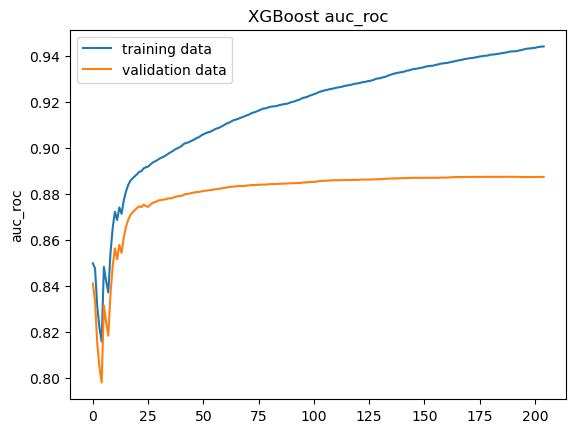

In [530]:
train_history = xgb1_fijo.evals_result()
epochs = len(train_history['validation_0']['auc'])
iterations = range(0, epochs)
plt.plot(iterations, train_history["validation_0"]["auc"], label="training data")
plt.plot(iterations, train_history["validation_1"]["auc"], label="validation data")
plt.legend()
pyplot.ylabel('auc_roc')
pyplot.title('XGBoost auc_roc')

In [531]:
xgb1_fijo.best_score

0.8875425758670876

In [532]:
# Predict on the evaluation set
y_pred_4 = xgb1_fijo.predict_proba(X_test)[:,1]
y_pred_4

array([3.77924815e-02, 1.10463814e-04, 1.09536245e-01, ...,
       1.54589477e-04, 7.89746717e-02, 4.79183182e-05], dtype=float32)

In [533]:
# Make the submission file
submission_df = pd.DataFrame({"ROW_ID": test_data["ROW_ID"], "conversion": y_pred_4})
submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
submission_df.to_csv("xgb1_fijo.csv", sep=",", index=False)

## Random Forest

In [ ]:
N_TREES = 100

# Definición de la función objetivo para Hyperopt
def objective(params):
    tree = DecisionTreeClassifier(**params, random_state=2345)
    tree.fit(X_train, y_train)
    y_preds_val_prob = tree.predict_proba(X_val)[:, tree.classes_ == True]
    score = roc_auc_score(y_val, y_preds_val_prob)
    return {'loss': -1 * score, 'status': STATUS_OK}

# Espacio de búsqueda para los hiperparámetros
space = {'criterion': hp.choice('criterion', ['gini', 'entropy', 'log_loss']),
         'splitter': hp.choice('splitter', ['best', 'random']),
         'max_depth': hp.uniformint('max_depth', 5, 12),
         'min_samples_split': hp.uniformint('min_samples_split', 2, 20),
         'min_samples_leaf': hp.uniformint('min_samples_leaf', 1, 20),
         'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0, 0.1)}

# Búsqueda de hiperparámetros óptimos con Hyperopt
best = fmin(objective, space,
            algo=tpe.suggest,
            max_evals=N_TREES,
            rstate=np.random.default_rng(3456)) 
best_tree_params = space_eval(space, best)

# Entrenamiento y evaluación del modelo Random Forest
rf = RandomForestClassifier(n_estimators=N_TREES, n_jobs=-1, verbose=1, oob_score=True)
rf.fit(pd.concat([X_train, X_val], axis=0),
       pd.concat([y_train, y_val], axis=0))

Obtenemos el siguiente score:

In [ ]:
rf.oob_score_